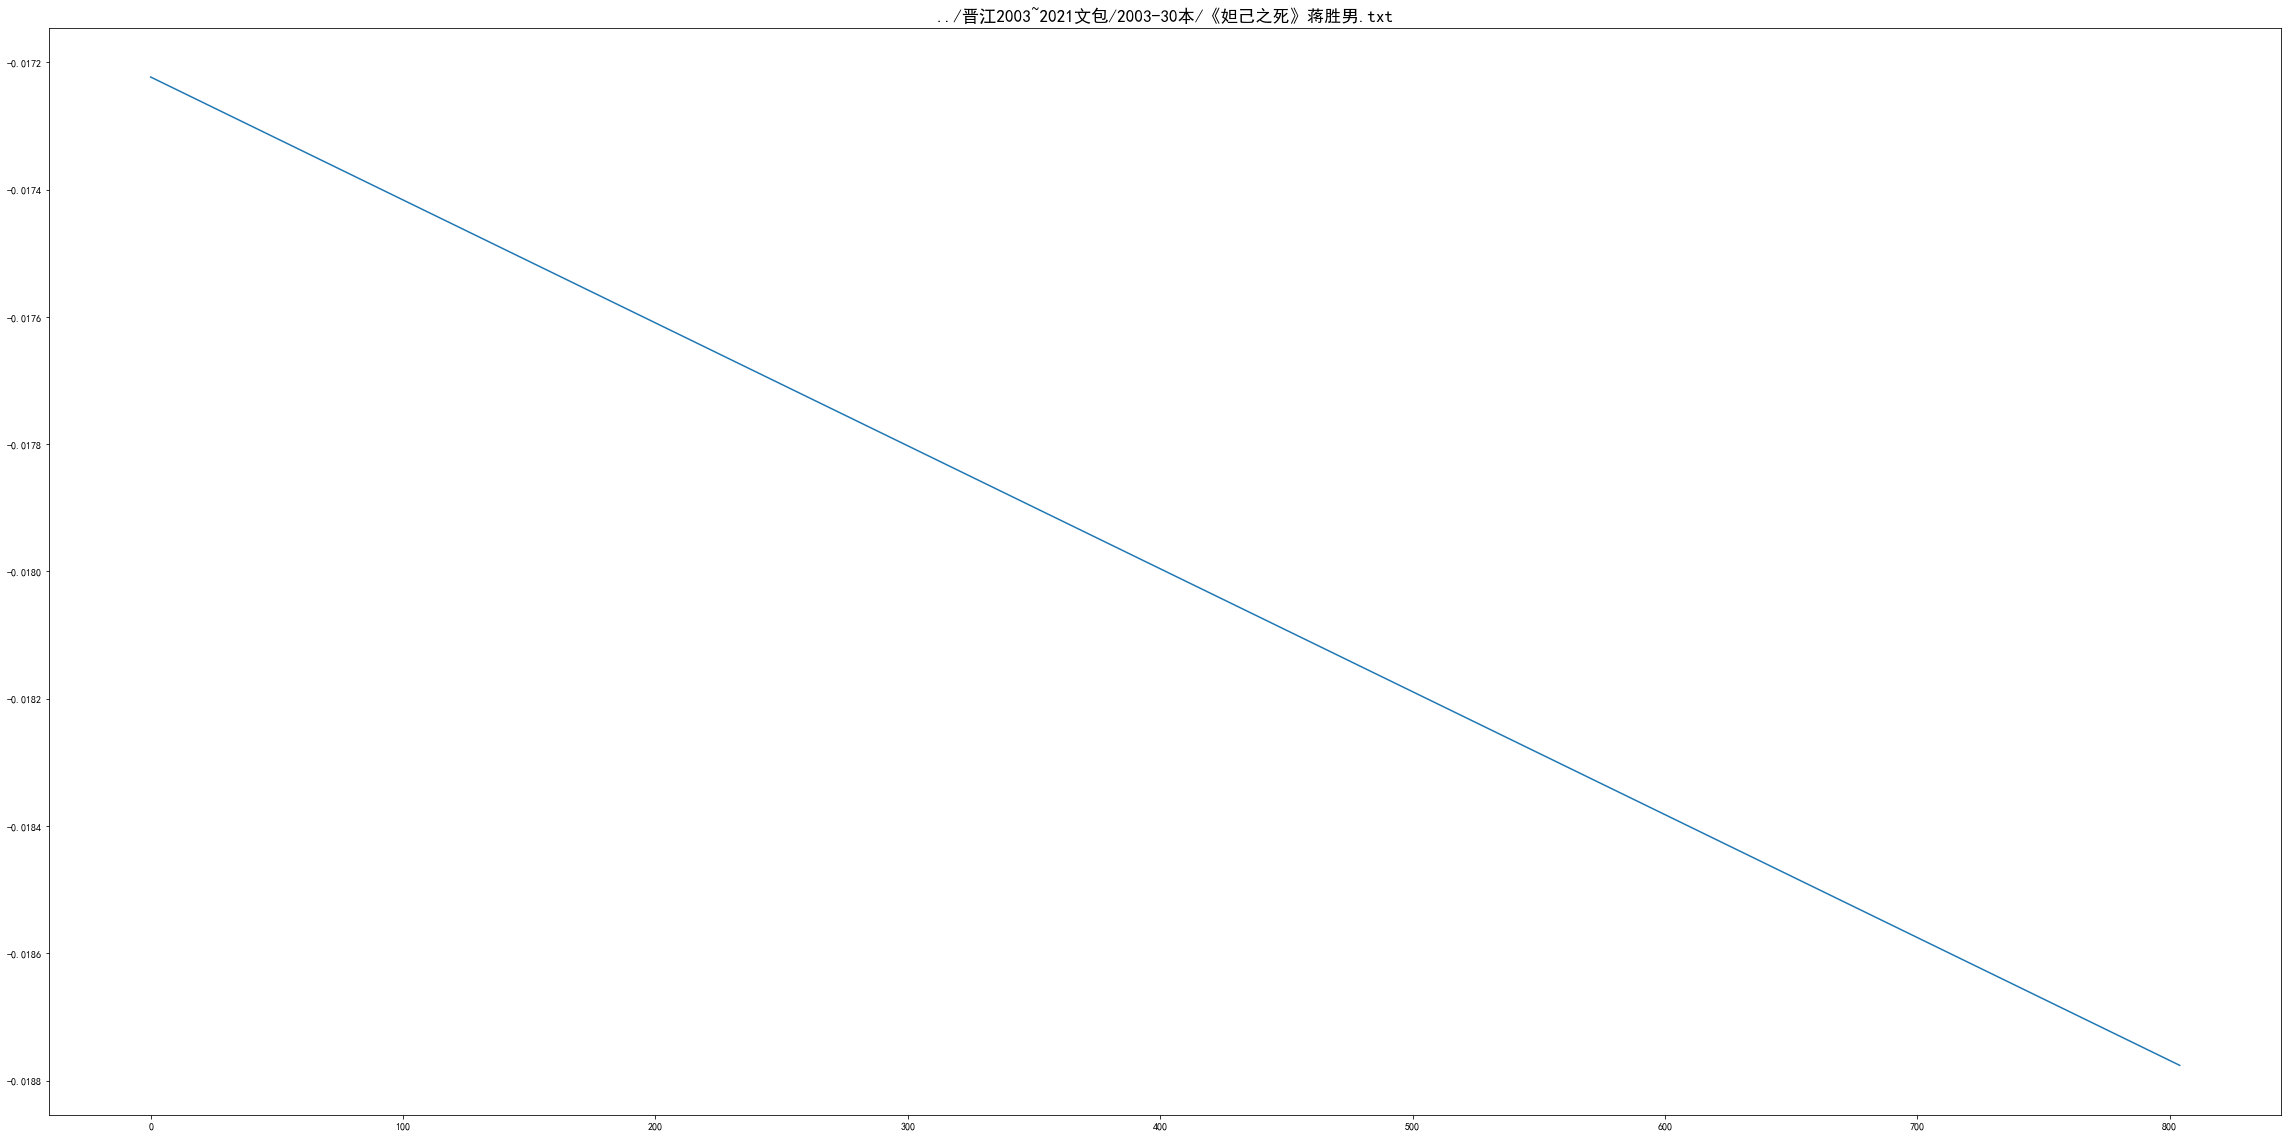

In [45]:
from networks import SentimentAnalysis
import re
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import numpy as np
SA = SentimentAnalysis()

# 评分函数
def predict(sent):
    """
    1: positif
    0: neutral
    -1: negatif
    """
    score1, score0 = SA.normalization_score(sent)
    if score1 == score0:
        result = 0
    elif score1 > score0:
        result = 1
    elif score1 < score0:
        result = -1
    return score1 - score0 #result

# 版本为python3，如果为python2需要在字符串前面加上u


# 分句函数
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 单字符断句符
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略号
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略号
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    # 如果双引号前有终止符，那么双引号才是句子的终点，把分句符\n放到双引号后，注意前面的几句都小心保留了双引号
    para = para.rstrip()  # 段尾如果有多余的\n就去掉它
    # 很多规则中会考虑分号;，但是这里我把它忽略不计，破折号、英文双引号等同样忽略，需要的再做些简单调整即可。
    return para.split("\n")

def get_sentiment_score(filename):
    """
    获取全文情感分数
    """
    s = []
    # 把此处的文件位置改成要分析的文件位置
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read()
        text = cut_sent(text)
        text = list(filter(None, text))
        for w in text:
            s.append(predict(w))
    return s, len(s)

def getarc(file_name, folder='',outdir='../output'):
    '''
    平滑曲线，画图，求波峰
    '''
    file_path = folder+file_name
    from scipy.signal import savgol_filter
    import os
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    try:
        s,slen=get_sentiment_score(file_path)
    except:
        print("file_path error",file_path)
    
    # 为了求均值时能有相同的基数，所以将窗口大小统一设置为201
    window_length =201 # min(slen//15*2+1,2001)
    writer=open(outdir+'/'+file_name,'a+',encoding='utf-8')
    writer.write('-'*30+'\n')
    writer.write(file_name +" 共%d个句子\n"%slen)
    writer.write("%.2f\n"%(np.mean(s)*100))

    plt.figure(figsize=(40,20))
    # 另一种平滑曲线的方法，效果不佳
    # data_x= np.linspace(1,len(s),len(s))
    # kr = KernelReg(s,data_x,'c')
    # s, _ = kr.fit(data_x)

    # 平滑曲线
    s=savgol_filter(s,  window_length, 2)
    s=savgol_filter(s,  window_length, 2)
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(s)

    plt.title( file_name,fontsize='xx-large')
    top_list=[]
    bot_list=[]
    
    for i in range(1,slen-1):
        if s[i]>s[i-1] and s[i]>s[i+1]:
            top_list.append(s[i])
            writer.write("第%d句出现波峰：%.2f\n%s%s%s\n"%(i,s[i]*100,text[i-1],text[i],text[i+1]))
        if s[i]<s[i-1] and s[i]<s[i+1]:
            bot_list.append(s[i])
            writer.write("第%d句出现波谷：%.2f\n%s%s%s\n"%(i,s[i]*100,text[i-1],text[i],text[i+1]))
    writer.write(file_name +" 共%d个起伏，波谷最值%.2f,波峰最值%.2f\n"%(len(top_list),min(bot_list)*100,max(top_list)*100))
    plt.show()
    # plt.savefig(os.path.join(outdir, file_name.split('.')[0]) + ".png")
    plt.close()
getarc('../晋江2003~2021文包/2003-30本/《妲己之死》蒋胜男.txt')


In [1]:
import os
files=['../晋江2003~2021文包/2009-50本/落花时节又逢君.txt']
# print(os.listdir('../晋江2003~2021文包'))
# for dir1 in os.listdir('../晋江2003~2021文包')[10:]:
#     for dir2 in os.listdir('../晋江2003~2021文包'+'/'+dir1):
#         files.append('../晋江2003~2021文包'+'/'+dir1+'/'+dir2)
# print(files)
#  folder = '../晋江2003~2021文包/2003-30本'
# outdir = '../outputs/2003'
# files = [os.path.join(folder, filename) for filename in os.listdir(folder)]


In [13]:
def save_npz(files):
    '''
    保存数组到.npz
    '''
    for filename in files:
        s, l = get_sentiment_score(filename)
        # print(filename, np.mean(s), l)
        file_path='../output/'+filename.split('/')[-2]
        if os.path.exists(file_path)==False:
            os.makedirs(file_path)
        np.savez(file_path+'/'+filename.split('/')[-1][:-4], s)
save_npz(files=['../晋江2003~2021文包/2008-50本/摩合罗传.txt'])

In [20]:
def getarc_v2(s):
    '''
    与getarc（）参数不同
    '''
    from scipy.signal import savgol_filter
    
    window_length = len(s)//15*2+1

    # plt.figure(figsize=(40,20))
    s=savgol_filter(s,  window_length, 2)
    s=savgol_filter(s,  window_length, 2)
    
    top_list=[]
    bot_list=[]
    
    for i in range(1,slen-1):
        if s[i]>s[i-1] and s[i]>s[i+1]:
            top_list.append(s[i])
            # writer.write("第%d句出现波峰：%.2f\n%s%s%s\n"%(i,s[i]*100,text[i-1],text[i],text[i+1]))
        if s[i]<s[i-1] and s[i]<s[i+1]:
            bot_list.append(s[i])
            # writer.write("第%d句出现波谷：%.2f\n%s%s%s\n"%(i,s[i]*100,text[i-1],text[i],text[i+1]))
    # writer.write(file_name +" 共%d个起伏，波谷最值%.2f,波峰最值%.2f\n"%(len(top_list),min(bot_list)*100,max(top_list)*100))
    # print(slen,len(top_list),len(bot_list),max(top_list),min(bot_list))
    # plt.show()
    # plt.savefig(os.path.join(outdir, file_name.split('.')[0]) + ".png")
    plt.close()

def npz2arc():
    # 导入npz到numpy
    import os
   
    folders=os.listdir('../output')
    for folder in folders:
        files=os.listdir('../output/'+folder)
        for file in files:
            file_path='../output/'+folder+'/'+file
            # print(file_path)
            data=np.load(file_path)['arr_0']
            
npz2arc()

243


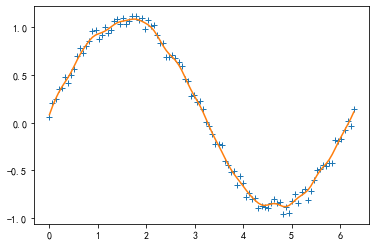

In [38]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2

kr = KernelReg(y,x,'c')
plt.plot(x, y, '+')
y_pred, y_std = kr.fit(x)

plt.plot(x, y_pred)
plt.show()


../晋江/黑月光拿稳BE剧本/第1章.txt ../晋江/黑月光拿稳BE剧本/第2章.txt ../晋江/黑月光拿稳BE剧本/第3章.txt ../晋江/黑月光拿稳BE剧本/第4章.txt ../晋江/黑月光拿稳BE剧本/第5章.txt ../晋江/黑月光拿稳BE剧本/第6章.txt ../晋江/黑月光拿稳BE剧本/第7章.txt ../晋江/黑月光拿稳BE剧本/第8章.txt ../晋江/黑月光拿稳BE剧本/第9章.txt ../晋江/黑月光拿稳BE剧本/第10章.txt ../晋江/黑月光拿稳BE剧本/第11章.txt ../晋江/黑月光拿稳BE剧本/第12章.txt ../晋江/黑月光拿稳BE剧本/第13章.txt ../晋江/黑月光拿稳BE剧本/第14章.txt ../晋江/黑月光拿稳BE剧本/第15章.txt ../晋江/黑月光拿稳BE剧本/第16章.txt ../晋江/黑月光拿稳BE剧本/第17章.txt ../晋江/黑月光拿稳BE剧本/第18章.txt ../晋江/黑月光拿稳BE剧本/第19章.txt ../晋江/黑月光拿稳BE剧本/第20章.txt ../晋江/黑月光拿稳BE剧本/第21章.txt ../晋江/黑月光拿稳BE剧本/第22章.txt ../晋江/黑月光拿稳BE剧本/第23章.txt ../晋江/黑月光拿稳BE剧本/第24章.txt ../晋江/黑月光拿稳BE剧本/第25章.txt ../晋江/黑月光拿稳BE剧本/第26章.txt ../晋江/黑月光拿稳BE剧本/第27章.txt ../晋江/黑月光拿稳BE剧本/第28章.txt ../晋江/黑月光拿稳BE剧本/第29章.txt ../晋江/黑月光拿稳BE剧本/第30章.txt ../晋江/黑月光拿稳BE剧本/第31章.txt ../晋江/黑月光拿稳BE剧本/第32章.txt ../晋江/黑月光拿稳BE剧本/第33章.txt ../晋江/黑月光拿稳BE剧本/第34章.txt ../晋江/黑月光拿稳BE剧本/第35章.txt ../晋江/黑月光拿稳BE剧本/第36章.txt ../晋江/黑月光拿稳BE剧本/第37章.txt ../晋江/黑月光拿稳BE剧本/第38章.txt ../晋江/黑月光拿稳BE剧本/第39章.txt ../晋江/黑月光拿稳BE剧本/第40章.txt ../晋江/黑月光

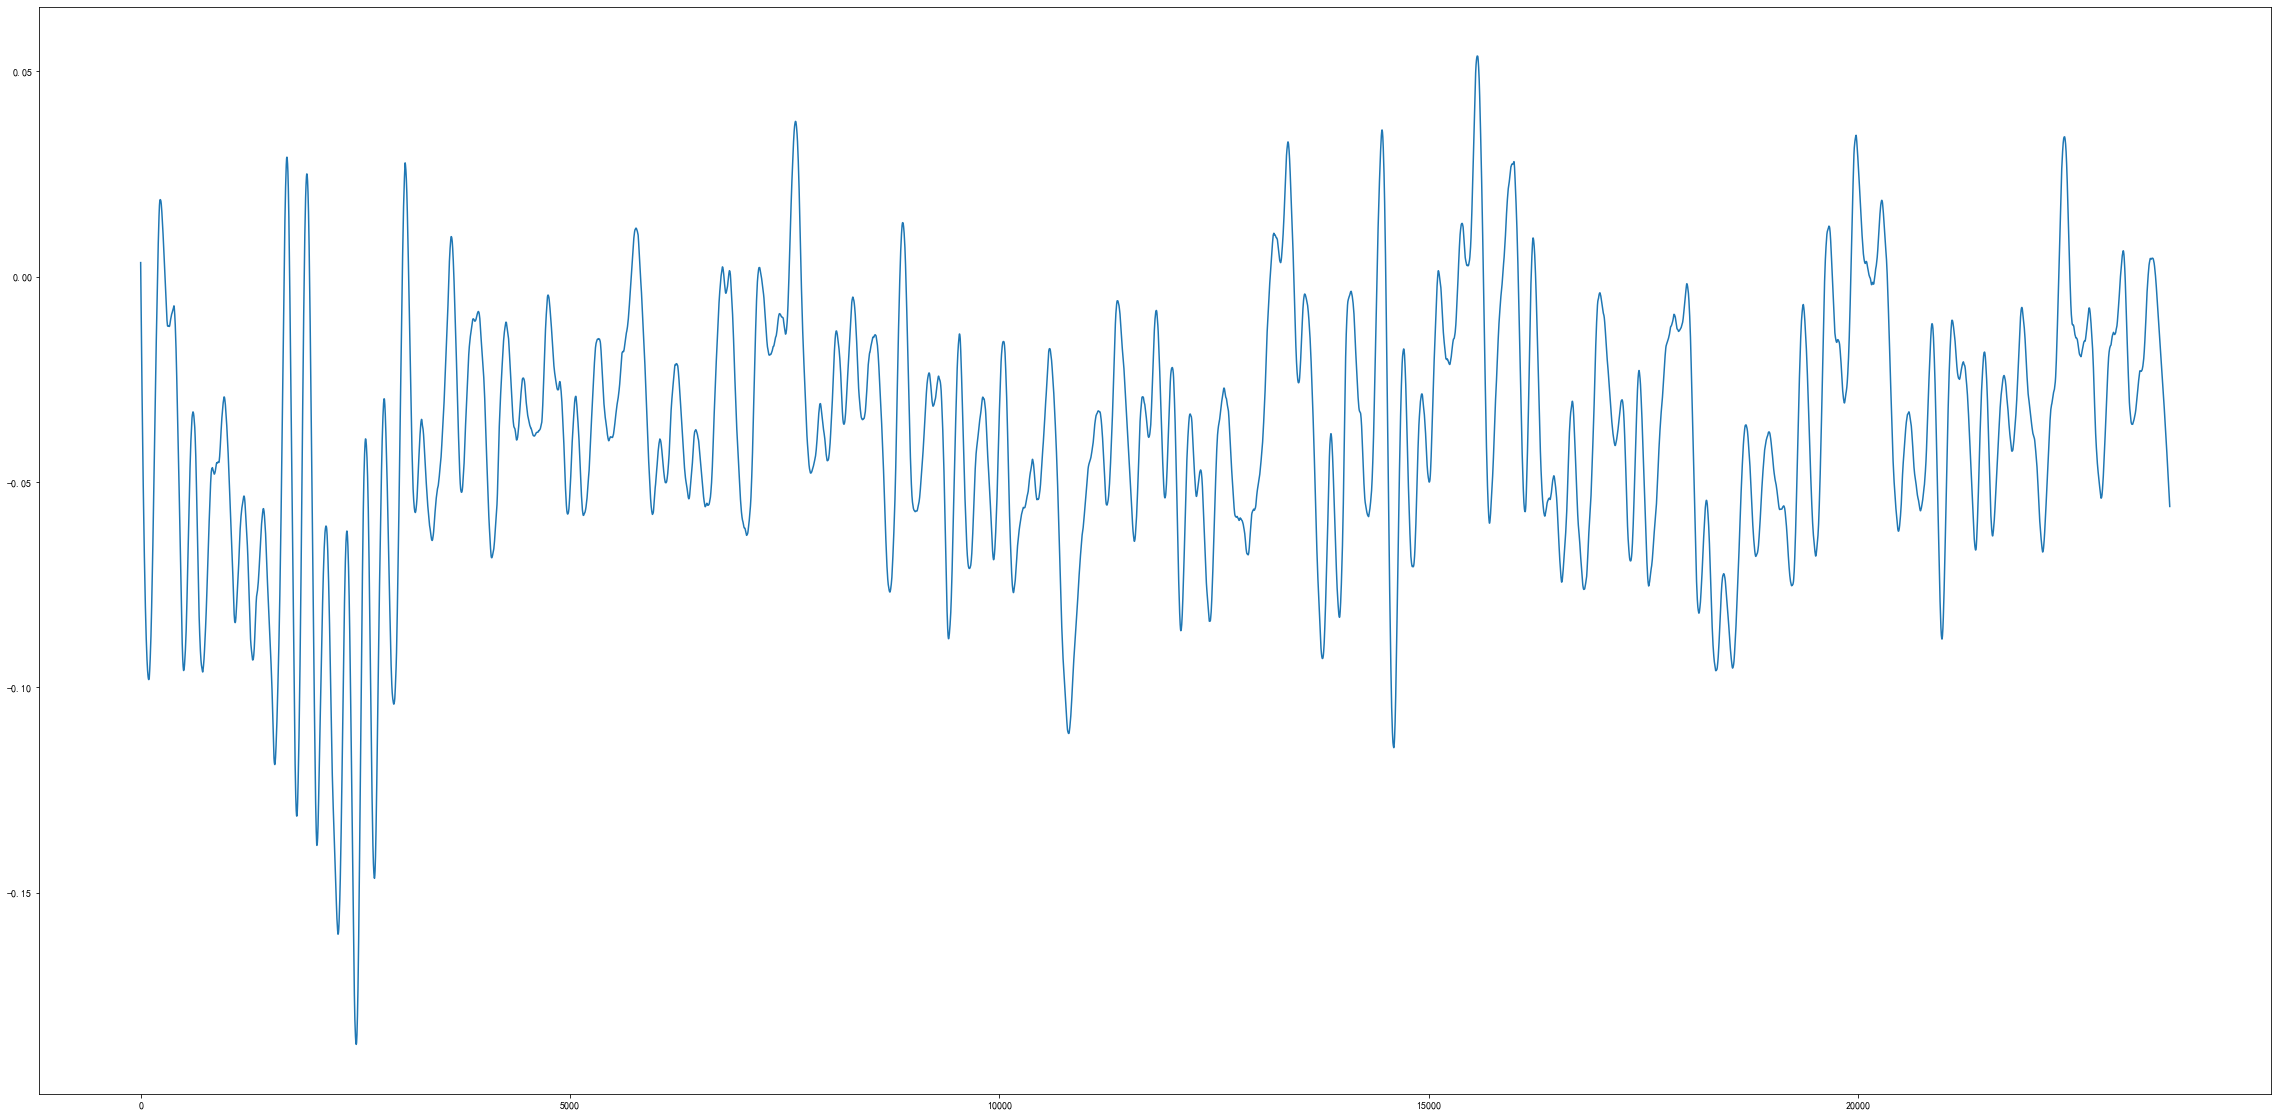

In [46]:
'''
2022/4/4晚，最新文本的测试
'''
def get_sentiment_score(folder):
    """
    获取全文情感分数
    """
    s = []
    # 把此处的文件位置改成要分析的文件位置
    # for filename in os.listdir(folder):
    for chapterid in range(1,130):
        filename='第%d章.txt'%chapterid
        print(folder+filename,end=' ')
        with open(folder+filename, 'r', encoding='utf-8') as f:
            text = f.read()
            text = cut_sent(text)
            text = list(filter(None, text))
        for w in text:
            s.append(predict(w))
    return s, len(s)

def getarc(folder='',outdir='../晋江/output'):
    
    from scipy.signal import savgol_filter
    import os
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    try:
        s,slen=get_sentiment_score(folder)
    except:
        print("file_path error")
    
    file_name=folder.split('/')[-1]
    window_length =201 # min(slen//15*2+1,2001)
    writer=open(outdir+'/'+file_name+'.txt','w',encoding='utf-8')
    writer.write('-'*30+'\n')
    writer.write(file_name +" 共%d个句子\n"%slen)
    writer.write("%.2f\n"%(np.mean(s)*100))

    plt.figure(figsize=(40,20))

    s=savgol_filter(s,  window_length, 2)
    s=savgol_filter(s,  window_length, 2)
    # plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(s)

    plt.title( file_name,fontsize='xx-large')
    top_list=[]
    bot_list=[]
    
    for i in range(1,slen-1):
        if s[i]>s[i-1] and s[i]>s[i+1]:
            top_list.append(s[i])
            # writer.write("第%d句出现波峰：%.2f\n%s%s%s\n"%(i,s[i]*100,text[i-1],text[i],text[i+1]))
        if s[i]<s[i-1] and s[i]<s[i+1]:
            bot_list.append(s[i])
            # writer.write("第%d句出现波谷：%.2f\n%s%s%s\n"%(i,s[i]*100,text[i-1],text[i],text[i+1]))
    # writer.write(file_name +" 共%d个起伏，波谷最值%.2f,波峰最值%.2f\n"%(len(top_list),min(bot_list)*100,max(top_list)*100))
    # print(slen,len(top_list),len(bot_list),max(top_list),min(bot_list))
    plt.show()
    # plt.savefig(os.path.join(outdir, file_name.split('.')[0]) + ".png")
    plt.close()
getarc(folder='../晋江/黑月光拿稳BE剧本/')